The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[0.6308646  0.32668227 0.0271879 ]
Gaussian Process Train R^2 0.9999714120152098
Gaussian Process Valid R^2 0.9987757820705587
Training set loss: 0.0008213935287138642
Testing Set Loss 0.033709965291826176
Gaussian Proccess Training Field Reconstruction Loss: 0.0005400469388203589
Gaussian Proccess Validation Field Reconstruction Loss: 0.0006988858346825118
PCA Training Field Reconstruction Loss 0.0005394781067367616
PCA Validation Field Reconstruction Loss 0.0006755409833723827


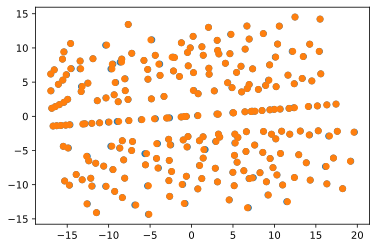

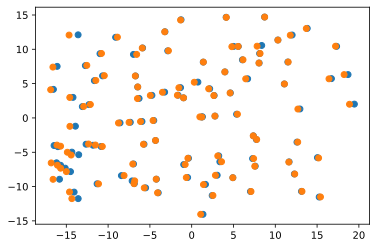

In [152]:
## Make Training Validation Set Split

from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from ssapp import Utils
from torch.utils.data.dataloader import DataLoader
from ssapp.data.AntennaDatasetLoaders import PatchAntennaDataset
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
from sklearn.gaussian_process.kernels import RBF
from sklearn import linear_model
import numpy as np

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2


dataset = PatchAntennaDataset()

train_data, test_data = Utils.train_test_data_split(dataset, TRAIN_TEST_RATIO = 0.7)

train_loader = DataLoader(train_data,batch_size=len(train_data),shuffle=True)
test_loader = DataLoader(test_data,batch_size=len(test_data),shuffle=True)

TRAIN_PARAMS,TRAIN_FIELDS = next(iter(train_loader))
TEST_PARAMS,TEST_FIELDS = next(iter(test_loader))


pca = PCA(n_components=3)
pca_train = pca.fit_transform(TRAIN_FIELDS.reshape((len(train_data),-1)))
print(pca.explained_variance_ratio_)
pca_val = pca.transform(TEST_FIELDS.reshape((len(TEST_FIELDS),-1)))


PCA_TRAIN_RECONSTRUCTED_FIELD = pca.inverse_transform(pca_train).reshape(len(TRAIN_FIELDS),361,3,4)
PCA_TEST_RECONSTRUCTED_FIELD = pca.inverse_transform(pca_val).reshape(len(TEST_FIELDS),361,3,4)


gpr = GaussianProcessRegressor().fit(TRAIN_PARAMS, pca_train) 
print('Gaussian Process Train R^2',gpr.score(TRAIN_PARAMS, pca_train))
print('Gaussian Process Valid R^2',gpr.score(TEST_PARAMS, pca_val))

TRAIN_LOSS = metrics.mean_squared_error(gpr.predict(TRAIN_PARAMS), pca_train)
TEST_LOSS = metrics.mean_squared_error(gpr.predict(TEST_PARAMS),pca_val)

print('Training set loss:', TRAIN_LOSS)
print('Testing Set Loss', TEST_LOSS)


PCA_TRAIN_RECONSTRUCTION_LOSS = metrics.mean_squared_error(TRAIN_FIELDS.flatten(), PCA_TRAIN_RECONSTRUCTED_FIELD.flatten())
PCA_TEST_RECONSTRUCTION_LOSS = metrics.mean_squared_error(TEST_FIELDS.flatten(), PCA_TEST_RECONSTRUCTED_FIELD.flatten())


## Loss in reconstruction
GPR_TRAIN_RECONSTRUCTED_FIELD = pca.inverse_transform(gpr.predict(TRAIN_PARAMS)).reshape(len(TRAIN_PARAMS),361,3,4)
GPR_TEST_RECONSTRUCTED_FIELD = pca.inverse_transform(gpr.predict(TEST_PARAMS)).reshape(len(TEST_PARAMS),361,3,4)

GPR_TRAIN_RECONSTRUCTION_LOSS = metrics.mean_squared_error(TRAIN_FIELDS.flatten(), GPR_TRAIN_RECONSTRUCTED_FIELD.flatten())
GPR_TEST_RECONSTRUCTION_LOSS = metrics.mean_squared_error(TEST_FIELDS.flatten(), GPR_TEST_RECONSTRUCTED_FIELD.flatten())




print('Gaussian Proccess Training Field Reconstruction Loss:',GPR_TRAIN_RECONSTRUCTION_LOSS)
print('Gaussian Proccess Validation Field Reconstruction Loss:',GPR_TEST_RECONSTRUCTION_LOSS)
print('PCA Training Field Reconstruction Loss',PCA_TRAIN_RECONSTRUCTION_LOSS)
print('PCA Validation Field Reconstruction Loss',PCA_TEST_RECONSTRUCTION_LOSS)


# Show Training Latent Space

plt.figure()
plt.scatter(pca_train[:,0],pca_train[:,1])
plt.scatter(gpr.predict(TRAIN_PARAMS)[:,0],gpr.predict(TRAIN_PARAMS)[:,1])

# Show Validation Latent Space

plt.figure()
plt.scatter(pca_val[:,0],pca_val[:,1])
plt.scatter(gpr.predict(TEST_PARAMS)[:,0],gpr.predict(TEST_PARAMS)[:,1])


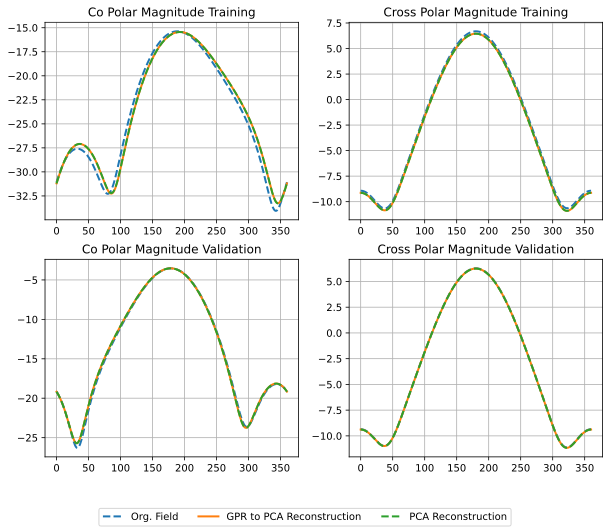

In [196]:
def mag_field(field,sample = 0,phi_cut = 0):
    co_polar = 20*np.log10(np.sqrt(field[sample,:,phi_cut,0]**2+field[sample,:,phi_cut,1]**2))
    cross_polar = 20*np.log10(np.sqrt(field[sample,:,phi_cut,2]**2+field[sample,:,phi_cut,3]**2))

    return co_polar, cross_polar

TRAIN_SAMPLE = 20
TEST_SAMPLE = 50

# Plot Training Field Reconstruction
fig,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

axs[0,0].set_title('Co Polar Magnitude Training')
org_co_polar, org_cross_polar = mag_field(TRAIN_FIELDS,sample = TRAIN_SAMPLE)
gpr_co_polar, gpr_cross_polar = mag_field(GPR_TRAIN_RECONSTRUCTED_FIELD,sample = TRAIN_SAMPLE)
pca_co_polar, pca_cross_polar = mag_field(PCA_TRAIN_RECONSTRUCTED_FIELD,sample = TRAIN_SAMPLE)

axs[0,0].plot(org_co_polar, label = 'Org. Field',linestyle =  '--')
axs[0,0].plot(gpr_co_polar,label = 'GPR to PCA Reconstruction')
axs[0,0].plot(pca_co_polar,label = 'PCA Reconstruction',linestyle =  '--')
fig.legend( loc = 'lower center',ncol = 3)

axs[0,1].set_title('Cross Polar Magnitude Training')
axs[0,1].plot(org_cross_polar, label = 'Org. Field',linestyle =  '--')
axs[0,1].plot(gpr_cross_polar,label = 'GPR to PCA Reconstruction')
axs[0,1].plot(pca_cross_polar,label = 'PCA Reconstruction',linestyle =  '--')

# Plot Validation Field Reconstruction

org_co_polar, org_cross_polar = mag_field(TEST_FIELDS,sample = TEST_SAMPLE)
gpr_co_polar, gpr_cross_polar = mag_field(GPR_TEST_RECONSTRUCTED_FIELD,sample = TEST_SAMPLE)
pca_co_polar, pca_cross_polar = mag_field(PCA_TEST_RECONSTRUCTED_FIELD,sample = TEST_SAMPLE)

axs[1,0].set_title('Co Polar Magnitude Validation')
axs[1,0].plot(org_co_polar, label = 'Org. Field',linestyle =  '--')
axs[1,0].plot(gpr_co_polar,label = 'GPR to PCA Reconstruction')
axs[1,0].plot(pca_co_polar,label = 'PCA Reconstruction',linestyle =  '--')

axs[1,1].set_title('Cross Polar Magnitude Validation')
axs[1,1].plot(org_cross_polar, label = 'Org. Field',linestyle =  '--')
axs[1,1].plot(gpr_cross_polar,label = 'GPR to PCA Reconstruction')
axs[1,1].plot(pca_cross_polar,label = 'PCA Reconstruction',linestyle =  '--')
for ax in axs.flatten():
    ax.grid(True)


# Test Point From Simon

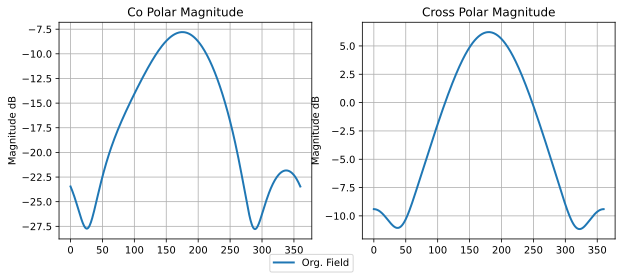

In [197]:


# Plot Training Field Reconstruction
fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))


## Make gpr Prediction
Test_Param_Point = np.array([[-1.5,8.5,3.04]])
Test_field = pca.inverse_transform(gpr.predict(Test_Param_Point)).reshape(1,361,3,4)

co_polar, cross_polar = mag_field(Test_field,phi_cut = 0)
axs[0].set_title('Co Polar Magnitude')
axs[0].plot(co_polar, label = 'Org. Field')
axs[0].set_ylabel('Magnitude dB')
fig.legend( loc = 'lower center',ncol = 3)

axs[1].set_title('Cross Polar Magnitude')
axs[1].plot(cross_polar, label = 'Org. Field')
axs[1].set_ylabel('Magnitude dB')

for ax in axs.flatten():
    ax.grid(True)

In [204]:
print(*(f"{i:+1.10E}" for i in Test_field[0,0,0,:]))
pirnt8
print(cross_polar[180])
print(max(cross_polar))
print('min val cross polar',min(cross_polar))

+1.4128567774E-02 -6.5654801927E-02 +5.5269116633E-02 -3.3415682141E-01


NameError: name 'pirnt8' is not defined

In [206]:
print(Test_field)

save

[[[[ 0.01412857 -0.0656548   0.05526912 -0.33415682]
   [-0.05526912  0.33415682  0.01412857 -0.0656548 ]
   [-0.01412857  0.0656548  -0.05526912  0.33415682]]

  [[ 0.01514527 -0.06420815  0.05504811 -0.33411153]
   [-0.0545      0.33496072  0.01482494 -0.06468536]
   [-0.01421414  0.0656158  -0.05440301  0.33524995]]

  [[ 0.01617079 -0.06269876  0.05460264 -0.33391983]
   [-0.05362011  0.33556213  0.01532899 -0.06381462]
   [-0.01425384  0.06554986 -0.05360579  0.33602506]]

  ...

  [[ 0.01212806 -0.06835687  0.05503709 -0.3338079 ]
   [-0.0564701   0.33194274  0.01216406 -0.06788747]
   [-0.01382017  0.06565172 -0.05720233  0.33101869]]

  [[ 0.01312229 -0.06703794  0.05526544 -0.33405551]
   [-0.05592621  0.3331506   0.01324112 -0.06672237]
   [-0.0139972   0.06566678 -0.0562027   0.33274611]]

  [[ 0.01412857 -0.0656548   0.05526912 -0.33415682]
   [-0.05526912  0.33415682  0.01412857 -0.0656548 ]
   [-0.01412857  0.0656548  -0.05526912  0.33415682]]]]


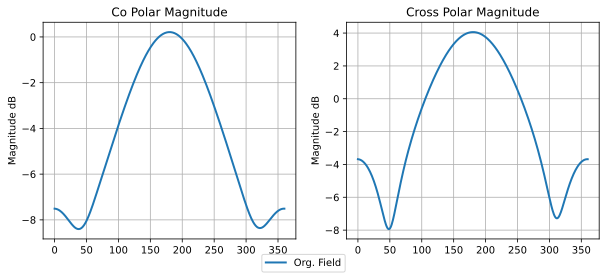

In [187]:

# Plot Training Field Reconstruction
fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))


## Make gpr Prediction
Test_Param_Point = np.array([[2.3,4.0,2.85]])
Test_field = pca.inverse_transform(gpr.predict(Test_Param_Point)).reshape(1,361,3,4)

co_polar, cross_polar = mag_field(Test_field,phi_cut = 2)
axs[0].set_title('Co Polar Magnitude')
axs[0].plot(co_polar, label = 'Org. Field')
axs[0].set_ylabel('Magnitude dB')
fig.legend( loc = 'lower center',ncol = 3)

axs[1].set_title('Cross Polar Magnitude')
axs[1].plot(cross_polar, label = 'Org. Field')
axs[1].set_ylabel('Magnitude dB')

for ax in axs.flatten():
    ax.grid(True)

In [92]:
## Gaussian Process Loss as functino of PCA Components

HIGH_NUM_PCA = 20

Number_PCAs = []

sweep_info = {
        'PCR Train Rec. Loss': [],
        'PCR Validation Rec. Loss': [],
        'GP Train Latent Loss': [],
        'GP Validation Latent Loss': [],
        'GP-PCA Train Rec. Loss': [],
        'GP-PCA Validation Rec. Loss': [],
        'LR-PCA Train Rec. Loss': [],
        'LR-PCA Validation Rec. Loss': []
        
        }

for num_pca in range(1,HIGH_NUM_PCA+1):

    Number_PCAs.append(num_pca)
    pca = PCA(n_components=num_pca)
    pca_train = pca.fit_transform(TRAIN_FIELDS.reshape((len(train_data),-1)))
    pca_val = pca.transform(TEST_FIELDS.reshape((len(TEST_FIELDS),-1)))

    PCA_TRAIN_RECONSTRUCTED_FIELD = pca.inverse_transform(pca_train).reshape(len(TRAIN_FIELDS),361,3,4)
    PCA_TEST_RECONSTRUCTED_FIELD = pca.inverse_transform(pca_val).reshape(len(TEST_FIELDS),361,3,4)

    gpr = GaussianProcessRegressor().fit(TRAIN_PARAMS, pca_train) 

    sweep_info['GP Train Latent Loss'].append(metrics.mean_squared_error(gpr.predict(TRAIN_PARAMS), pca_train))
    sweep_info['GP Validation Latent Loss'].append(metrics.mean_squared_error(gpr.predict(TEST_PARAMS),pca_val))

    sweep_info['PCR Train Rec. Loss'].append(metrics.mean_squared_error(TRAIN_FIELDS.flatten(), PCA_TRAIN_RECONSTRUCTED_FIELD.flatten()))
    sweep_info['PCR Validation Rec. Loss'].append(metrics.mean_squared_error(TEST_FIELDS.flatten(), PCA_TEST_RECONSTRUCTED_FIELD.flatten()))

    ## Loss in reconstruction
    GPR_TRAIN_RECONSTRUCTED_FIELD = pca.inverse_transform(gpr.predict(TRAIN_PARAMS)).reshape(len(TRAIN_PARAMS),361,3,4)
    GPR_TEST_RECONSTRUCTED_FIELD = pca.inverse_transform(gpr.predict(TEST_PARAMS)).reshape(len(TEST_PARAMS),361,3,4)

    LR = LinearRegression().fit(TRAIN_PARAMS, pca_train) 

    LR_TRAIN_RECONSTRUCTED_FIELD = pca.inverse_transform(LR.predict(TRAIN_PARAMS)).reshape(len(TRAIN_PARAMS),361,3,4)
    LR_TEST_RECONSTRUCTED_FIELD = pca.inverse_transform(LR.predict(TEST_PARAMS)).reshape(len(TEST_PARAMS),361,3,4)

    sweep_info['GP-PCA Train Rec. Loss'].append(metrics.mean_squared_error(TRAIN_FIELDS.flatten(), GPR_TRAIN_RECONSTRUCTED_FIELD.flatten()))
    sweep_info['GP-PCA Validation Rec. Loss'].append(metrics.mean_squared_error(TEST_FIELDS.flatten(), GPR_TEST_RECONSTRUCTED_FIELD.flatten()))

    sweep_info['LR-PCA Train Rec. Loss'].append(metrics.mean_squared_error(TRAIN_FIELDS.flatten(), LR_TRAIN_RECONSTRUCTED_FIELD.flatten()))
    sweep_info['LR-PCA Validation Rec. Loss'].append(metrics.mean_squared_error(TEST_FIELDS.flatten(), LR_TEST_RECONSTRUCTED_FIELD.flatten()))




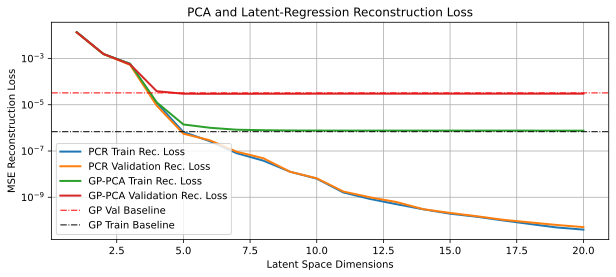

In [118]:
plt.figure(figsize = (10,4))
plt.semilogy(Number_PCAs,sweep_info['PCR Train Rec. Loss'],label ='PCR Train Rec. Loss' )
plt.semilogy(Number_PCAs,sweep_info['PCR Validation Rec. Loss'],label='PCR Validation Rec. Loss')
plt.semilogy(Number_PCAs,sweep_info['GP-PCA Train Rec. Loss'],label = 'GP-PCA Train Rec. Loss')
plt.semilogy(Number_PCAs,sweep_info['GP-PCA Validation Rec. Loss'],label = 'GP-PCA Validation Rec. Loss')
plt.axhline(3.2447262845002656e-05,color = 'red',linestyle = '-.',linewidth = 1,label = 'GP Val Baseline')
plt.axhline(6.84051583744767e-07,color = 'black',linestyle = '-.',linewidth = 1,label = 'GP Train Baseline')
plt.legend()
plt.xlabel('Latent Space Dimensions')
plt.ylabel('MSE Reconstruction Loss')
plt.title('PCA and Latent-Regression Reconstruction Loss')
plt.grid(True)

In [106]:
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge,SGDRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import LinearSVR
import pandas as pd 

benchmark_models = {'Gaus. Proc.':GaussianProcessRegressor(),
                    'Linear Reg.':LinearRegression(),
                    'Ridge Reg.': Ridge()}

test_metrics = {'Mean Squared':metrics.mean_squared_error,
                'MAPE':metrics.mean_absolute_percentage_error,
                'R Squared':metrics.r2_score,
                'Max Error': metrics.max_error,
                'Explained Variance': metrics.explained_variance_score}


test_loss_dict = dict.fromkeys(test_metrics.keys(),[])

test_df = pd.DataFrame()

for name,model in benchmark_models.items():

    print(name)
    model.fit(TRAIN_PARAMS, TRAIN_FIELDS.reshape(len(TRAIN_FIELDS),-1))

    for test_name,test_metric in test_metrics.items():
        test_loss_dict[test_name].append()
        print(test_metric(TRAIN_FIELDS.flatten(),model.predict(TRAIN_PARAMS).flatten()))
        print('Valid')
        print(test_metric(TEST_FIELDS.flatten(),model.predict(TEST_PARAMS).flatten()))



Gaus. Proc.
Mean Squared
Test
7.598551945139721e-07
Valid
3.004054305985123e-05
MAPE
Test
0.03878235108765916
Valid
0.13771511217823348
R Squared
Test
0.9999970596498121
Valid
0.9998837105074523
Max Error
Test
0.012063240758680482
Valid
0.0748862032691449
Explained Variance
Test
0.9999970596498121
Valid
0.999883743442572
Linear Reg.
Mean Squared
Test
0.002280886552543672
Valid
0.002231271173976546
MAPE
Test
2.0349087130092007
Valid
0.8848837908831341
R Squared
Test
0.9911738377893432
Valid
0.9913625598564855
Max Error
Test
0.4089090026437714
Valid
0.36056258147107545
Explained Variance
Test
0.991173837789407
Valid
0.9913686647996138
Ridge Reg.
Mean Squared
Test
0.006911420957550602
Valid
0.006355381403573102
MAPE
Test
2.2358391169228025
Valid
1.0798515613120714
R Squared
Test
0.9732554333272538
Valid
0.9753977790316107
Max Error
Test
0.5328030770850681
Valid
0.5596854254250112
Explained Variance
Test
0.9732554333272538
Valid
0.9754040352709437


In [115]:
Number_PCAs.append(num_pca)
pca = PCA(n_components=num_pca)
pca_train = pca.fit_transform(TRAIN_FIELDS.reshape((len(train_data),-1)))
pca_val = pca.transform(TEST_FIELDS.reshape((len(TEST_FIELDS),-1)))

PCA_TRAIN_RECONSTRUCTED_FIELD = pca.inverse_transform(pca_train).reshape(len(TRAIN_FIELDS),361,3,4)
PCA_TEST_RECONSTRUCTED_FIELD = pca.inverse_transform(pca_val).reshape(len(TEST_FIELDS),361,3,4)

gpr = GaussianProcessRegressor().fit(TRAIN_PARAMS, pca_train) 



[['Mean Squared_Val', 'Mean Squared_Test'],
 ['MAPE_Val', 'MAPE_Test'],
 ['R Squared_Val', 'R Squared_Test'],
 ['Max Error_Val', 'Max Error_Test'],
 ['Explained Variance_Val', 'Explained Variance_Test']]